# INFO 3401 – Class 21: Forecasting with autocorrelation and prophet

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This lecture will introduce forecasting, one of the most common data analysis tasks when working with time series data.

* Review content about temporal structure, additive models, and autocorrelation
* Using the `statsmodels` and `prophet` libraries to forecast temporal data
* Making and interpreting forecasts using DIA, BEST, and other time series data

## Background

Last week we covered many different functions, methods, and attributes for working with temporal data in pandas and finding common patterns in temporal data. This week we will use this knowledge to make forecasts of what the future using historical data, apply different forecasting methods and tools, and evaluate the performance of forecasts.

## Load libraries

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

# Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Statistical analysis libraries
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Load data

In [2]:
# Read in the data
den_pass_df = pd.read_csv('den_passengers.csv',index_col=0)

# Cast the index to periods then timestamps
den_pass_df.index = pd.to_datetime(den_pass_df.index)#[0],den_pass_df.index[-1],freq='M').to_timestamp()

# Park the original columns
orig_cols = den_pass_df.columns

# Inspect
print(den_pass_df.shape)
den_pass_df.tail(10)

(307, 7)


,American,Delta,Frontier,Other,Southwest,United Express,United
2019-11-01,248838,271136,645543,269124,1502102.0,653590,1713647
2019-12-01,285504,312654,558746,306029,1661202.0,749165,1915520
2020-01-01,252609,277318,527185,282431,1407678.0,685777,1765230
2020-02-01,236439,263292,493984,258516,1306590.0,694512,1655042
2020-03-01,146987,150119,306420,147830,770226.0,438251,963524
2020-04-01,25272,14773,29753,8748,89035.0,41679,89838
2020-05-01,48289,28214,144702,14486,320493.0,120265,158422
2020-06-01,74928,48656,323277,45765,809923.0,197807,250012
2020-07-01,154607,81130,479485,148904,945160.0,294247,488744
2020-08-01,171353,105907,533026,136293,951646.0,339484,747851


Engineer new features (from Class 20 notebook).

In [3]:
den_pass_df['Total'] = den_pass_df[orig_cols].sum(1)
den_pass_df['Rolling Total'] = den_pass_df['Total'].rolling(12).mean()
den_pass_df['months_open'] = (den_pass_df.index - pd.Timestamp('1995-02-01'))/pd.Timedelta(30,'D')

# Inspect
den_pass_df.tail()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total,months_open
2020-04-01,25272,14773,29753,8748,89035.0,41679,89838,299098.0,5.172371e+06,306.366667
2020-05-01,48289,28214,144702,14486,320493.0,120265,158422,834871.0,4.738468e+06,307.366667
2020-06-01,74928,48656,323277,45765,809923.0,197807,250012,1750368.0,4.352193e+06,308.400000
2020-07-01,154607,81130,479485,148904,945160.0,294247,488744,2592277.0,4.007159e+06,309.400000
2020-08-01,171353,105907,533026,136293,951646.0,339484,747851,2985560.0,3.718033e+06,310.433333


Visualize (from Class 20 notebook).

Text(2020-01, 500000.0, 'COVID-19 shutdowns')

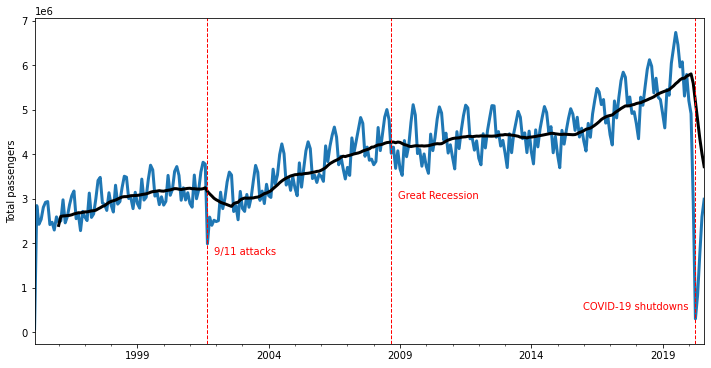

In [4]:
f,ax = plt.subplots(figsize=(12,6))
den_pass_df['Total'].plot(lw=3,ax=ax)
den_pass_df['Rolling Total'].plot(lw=3,ax=ax,c='k')

ax.set_ylabel('Total passengers')

# Annotate
ax.axvline(pd.Period('2001-09'),c='r',ls='--',lw=1)
ax.text(pd.Period('2001-09')+3,1.75e6,'9/11 attacks',c='r')

ax.axvline(pd.Period('2008-09'),c='r',ls='--',lw=1)
ax.text(pd.Period('2008-09')+3,3e6,'Great Recession',c='r')

ax.axvline(pd.Period('2020-04'),c='r',ls='--',lw=1)
ax.text(pd.Period('2020-04')-3,5e5,'COVID-19 shutdowns',c='r',ha='right')

# f.savefig('den_passengers.png',dpi=300)

## Forecasting with lag (pre-class)

We also know that autocorrelation in temporal data explains a lot of variance in time series data: the state of the world yesterday tends to be similar to today which tends to be similar to tomorrow.

We can use statsmodel's `plot_acf` function to plot the auto-correlation of this time series. You could also use pandas's `autocorrelation_plot`.

Text(0, 0.5, 'Correlation')

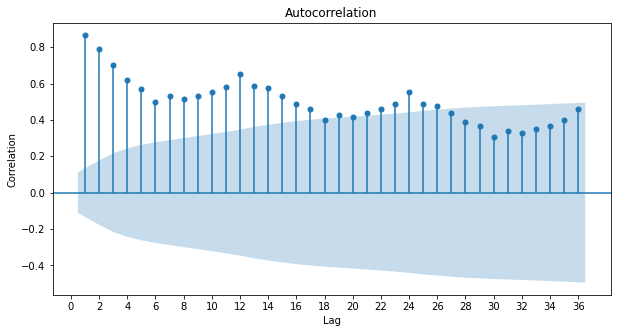

In [7]:
# Make an empty plot to fill
f,ax = plt.subplots(figsize=(10,5))

# Make the plot and prevent a double figure from being produced by catching the output with p
p = sm.graphics.tsa.plot_acf(den_pass_df['Total'],ax=ax,zero=False,lags=36)

# Give me some more ticks
ax.set_xticks(range(0,37,2))
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')

We can use pandas's `.shift()` method to compute these correlations as well.

In [14]:
shift_df = pd.DataFrame({'Total':den_pass_df['Total'],
                         'Lag1':den_pass_df['Total'].shift(1),
                         'Lag2':den_pass_df['Total'].shift(2),
                         'Lag3':den_pass_df['Total'].shift(3),
                         'Lag4':den_pass_df['Total'].shift(4)
                        })

shift_df = shift_df.loc['1995-06-01':]
shift_df.head(10)

,Total,Lag1,Lag2,Lag3,Lag4
1995-06-01,2803418.0,2532545.0,2422712.0,2842669.0,70562.0
1995-07-01,2917049.0,2803418.0,2532545.0,2422712.0,2842669.0
1995-08-01,2933160.0,2917049.0,2803418.0,2532545.0,2422712.0
1995-09-01,2415564.0,2933160.0,2917049.0,2803418.0,2532545.0
1995-10-01,2469394.0,2415564.0,2933160.0,2917049.0,2803418.0
1995-11-01,2293523.0,2469394.0,2415564.0,2933160.0,2917049.0
1995-12-01,2589163.0,2293523.0,2469394.0,2415564.0,2933160.0
1996-01-01,2475317.0,2589163.0,2293523.0,2469394.0,2415564.0
1996-02-01,2499223.0,2475317.0,2589163.0,2293523.0,2469394.0
1996-03-01,2972450.0,2499223.0,2475317.0,2589163.0,2293523.0


In [19]:
np.corrcoef(shift_df['Total'],shift_df['Lag4'])[0,1]

0.6547206852141673

## Comparing model performance (pre-class)
Now we'll estimate a regression model incorporating the "Lag1" variable to see how it affects performance.

In [27]:
# Feature engineering to add in months and opened
shift_df['months_open'] = (shift_df.index - pd.Timestamp('1995-02-01'))/pd.Timedelta(30,'D')
shift_df['month'] = [i.month for i in shift_df.index]

# Estimate Model 0 from Class 20 with only a linear trend
m0 = smf.ols('Total ~ months_open',data=shift_df).fit()

# Estimate Model 1 from Class 20 with a linear trend and a fixed effect for month
m1 = smf.ols('Total ~ months_open + C(month)',data=shift_df).fit()

# Estimate a new Model 2 with a linear trend and a lagged variable
m2 = smf.ols('Total ~ months_open + Lag1',data=shift_df).fit()

# Estimate a new Model 3 with a linear trend, fixed effects for months, and a lagged variable
m3 = smf.ols('Total ~ months_open + C(month) + Lag1',data=shift_df).fit()

# Estimate a new Model 4 with a linear trend, fixed effects for months, and multiple lagged variables
m4 = smf.ols('Total ~ months_open + C(month) + Lag1 + Lag2 + Lag3 + Lag4',data=shift_df).fit()

In [39]:
m3.rsquared

0.9351093178419039

Compare the R2 values

In [41]:
for _i, _m in enumerate([m0,m1,m2,m3,m4]):
    print("The R2 for m{0} is: {1:.4f}".format(_i, _m.rsquared))

The R2 for m0 is: 0.5409
The R2 for m1 is: 0.6484
The R2 for m2 is: 0.8124
The R2 for m3 is: 0.9351
The R2 for m4 is: 0.9437


Put the predictions for each model back into `shift_df` to compare.

In [45]:
shift_df['m0'] = m0.predict({'months_open':shift_df['months_open']})

shift_df['m1'] = m1.predict({'months_open':shift_df['months_open'],
                             'month':shift_df['month']
                            })

shift_df['m2'] = m2.predict({'months_open':shift_df['months_open'],
                             'Lag1':shift_df['Lag1']
                            })

shift_df['m3'] = m3.predict({'months_open':shift_df['months_open'],
                             'month':shift_df['month'],
                             'Lag1':shift_df['Lag1']
                            })

shift_df['m4'] = m4.predict({'months_open':shift_df['months_open'],
                             'month':shift_df['month'],
                             'Lag1':shift_df['Lag1'],
                             'Lag2':shift_df['Lag2'],
                             'Lag3':shift_df['Lag3'],
                             'Lag4':shift_df['Lag4']
                            })

In [46]:
shift_df.tail(10)

,Total,Lag1,Lag2,Lag3,Lag4,months_open,month,m0,m1,m2,m3,m4
2019-11-01,5303980.0,6073368.0,5958092.0,6455071.0,6732686.0,301.300000,11,5.079717e+06,4.790181e+06,5.842241e+06,5.641464e+06,5.584676e+06
2019-12-01,5788820.0,5303980.0,6073368.0,5958092.0,6455071.0,302.300000,12,5.087818e+06,5.035887e+06,5.241332e+06,5.492748e+06,5.311202e+06
2020-01-01,5198228.0,5788820.0,5303980.0,6073368.0,5958092.0,303.333333,1,5.096189e+06,4.779757e+06,5.622731e+06,5.460780e+06,5.511950e+06
2020-02-01,4908375.0,5198228.0,5788820.0,5303980.0,6073368.0,304.366667,2,5.104560e+06,4.627766e+06,5.161901e+06,4.995267e+06,4.860252e+06
2020-03-01,2923357.0,4908375.0,5198228.0,5788820.0,5303980.0,305.333333,3,5.112391e+06,5.245335e+06,4.936487e+06,5.483419e+06,5.419495e+06
2020-04-01,299098.0,2923357.0,4908375.0,5198228.0,5788820.0,306.366667,4,5.120762e+06,4.771019e+06,3.383609e+06,2.569649e+06,1.729003e+06
2020-05-01,834871.0,299098.0,2923357.0,4908375.0,5198228.0,307.366667,5,5.128863e+06,5.087019e+06,1.330052e+06,8.703156e+05,2.948414e+05
2020-06-01,1750368.0,834871.0,299098.0,2923357.0,4908375.0,308.400000,6,5.137235e+06,5.451745e+06,1.751339e+06,1.443146e+06,1.786060e+06
2020-07-01,2592277.0,1750368.0,834871.0,299098.0,2923357.0,309.400000,7,5.145336e+06,5.719114e+06,2.469953e+06,2.223677e+06,2.691980e+06
2020-08-01,2985560.0,2592277.0,1750368.0,834871.0,299098.0,310.433333,8,5.153707e+06,5.626908e+06,3.130991e+06,2.670040e+06,3.106335e+06


Visualize the model predictions. Note how it's hard to see the differences in the M2, M3, and M4 predictions during the  COVID-19 shutdowns.

<AxesSubplot:xlabel='months_open'>

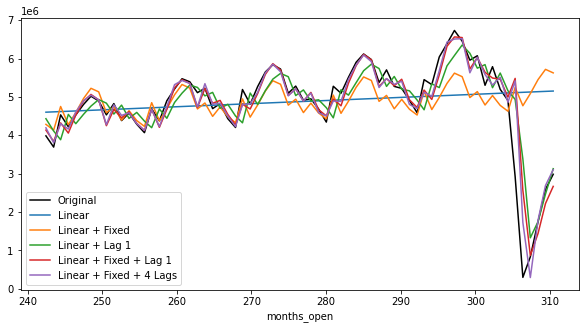

In [56]:
f,ax = plt.subplots(figsize=(10,5))

# Make a temporary DataFrame for to "zoom in"
_df = shift_df.loc['2015-01-01':]

# Start visualizing
_df.plot.line(x='months_open',y='Total',c='k',label='Original',ax=ax)
_df.plot.line(x='months_open',y='m0',c='tab:blue',label='Linear',ax=ax)
_df.plot.line(x='months_open',y='m1',c='tab:orange',label='Linear + Fixed',ax=ax)
_df.plot.line(x='months_open',y='m2',c='tab:green',label='Linear + Lag 1',ax=ax)
_df.plot.line(x='months_open',y='m3',c='tab:red',label='Linear + Fixed + Lag 1',ax=ax)
_df.plot.line(x='months_open',y='m4',c='tab:purple',label='Linear + Fixed + 4 Lags',ax=ax)

Residuals are the remaining variance in the data not explained by the model. They are what's "left over" that the model couldn't predict. If you subtracted the observed data values from the model predictions, you would get residuals. 

Plot the residuals to see the errors different models make and how quickly the models with lagged terms catch back up with the observed data during the COVID-19 shutdowns.

In [59]:
m0.resid

1995-06-01    1.321673e+05
1995-07-01    2.376971e+05
1995-08-01    2.454370e+05
1995-09-01   -2.805302e+05
1995-10-01   -2.348013e+05
                  ...     
2020-04-01   -4.821664e+06
2020-05-01   -4.293992e+06
2020-06-01   -3.386867e+06
2020-07-01   -2.553059e+06
2020-08-01   -2.168147e+06
Length: 303, dtype: float64

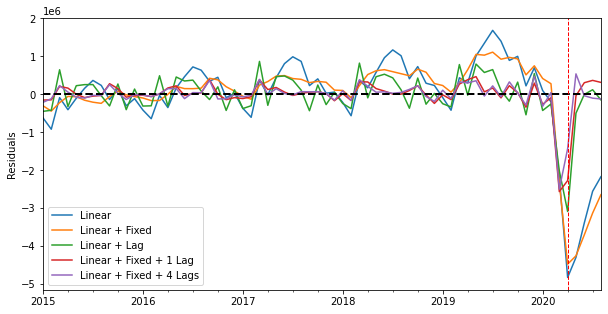

In [67]:
residuals_df = pd.DataFrame({'Linear':m0.resid,
                             'Linear + Fixed':m1.resid,
                             'Linear + Lag':m2.resid,
                             'Linear + Fixed + 1 Lag':m3.resid,
                             'Linear + Fixed + 4 Lags':m4.resid
                            })

f,ax = plt.subplots(figsize=(10,5))
residuals_df.loc['2015-01-01':].plot(ax=ax)

# Annotate
ax.set_ylabel('Residuals')
ax.axhline(0,c='k',ls='--',lw=2)
ax.axvline(pd.Timestamp('2001-09-01'),c='r',ls='--',lw=1)
ax.axvline(pd.Timestamp('2008-09-01'),c='r',ls='--',lw=1)
ax.axvline(pd.Timestamp('2020-04-01'),c='r',ls='--',lw=1)

## Autoregressive time-series models (pre-class)

The way we specified autoregressive or lagged terms in the model above ("Lag1", *etc*.) required a fair bit of work. statsmodels has a class of functions called [`AutoReg`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html) that allow us to estimate autoregression time-series models in a much quicker way than feature engineering with extracting months, creating shifts, specifying model parameters, *etc*. like we did above.

In [68]:
from statsmodels.tsa.ar_model import AutoReg

We specify and fit the a Model 5 ("m5") on the original "Total" data from `den_pass_df`, and ([following the documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html)) specify which lags we want to use (1, like we did above), whether to include a constant and/or trend terms (yes, like we did above), and whether to model seasonality effects (yes, like the fixed effects above).

The summary on our fit model has an intercept and trend like we did before (m0 was a simple intercept and trend model) plus modeling seasonality (m1 incorporated fixed effects on month plus trend), and a lag term (m2 incorporated trend and lag). So this model is similar but not identical to model 3. There's no R2 value and other model fit parameters liek AIC, BIC, and log-likelihood can't really be compared to m3.

In [84]:
# Make a simple series
den_total_s = den_pass_df['Total'].copy()

_new_index = pd.date_range(den_total_s.index.min(),
                           den_total_s.index.max(),
                           freq='MS')

den_total_s.index = _new_index

# Specify and fit the model
m5 = AutoReg(den_total_s,lags=[1],trend='ct',seasonal=True).fit()

# Summarize
m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Total   No. Observations:                  307
Model:               Seas. AutoReg(1)   Log Likelihood               -4262.283
Method:               Conditional MLE   S.D. of innovations         271058.424
Date:                Fri, 09 Oct 2020   AIC                             25.118
Time:                        15:23:24   BIC                             25.301
Sample:                    03-01-1995   HQIC                            25.191
                         - 08-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    1.277e+05   8.66e+04      1.475      0.140    -4.2e+04    2.97e+05
trend         571.8865    291.445      1.962      0.050       0.665    1143.108
seasonal.1   8.262e+05   7.62e+04     10.840      0.000    6.77e+05    9.76e+05
seasonal.2  -2.749e+05   7.69e+04     -3.574      0.000   -4.26e+05   -1.24e+05
seasonal.3   4.563e+05   7.59e+04      6.009      0.000    3.07e+05    6.05e+05
seasonal.4   5.473e+05   7.63e+04      7.175      0.000    3.98e+05    6.97e+05
seasonal.5   4.839e+05   7.79e+04      6.215      0.000    3.31e+05    6.36e+05
seasonal.6   1.512e+05   7.97e+04      1.897      0.058   -5024.244    3.07e+05
seasonal.7  -4.071e+05   8.05e+04     -5.058      0.000   -5.65e+05   -2.49e+05
seasonal.8   3.301e+05   7.69e+04      4.290      0.000    1.79e+05    4.81e+05
seasonal.9   -1.58e+05   7.74e+04     -2.042      0.041    -3.1e+05   -6348.518
seasonal.10  3.999e+05   7.67e+04      5.216      0.000     2.5e+05     5.5e+05
seasonal.11 -7.725e+04    7.7e+04     -1.003      0.316   -2.28e+05    7.37e+04
Total.L1        0.8972      0.027     32.862      0.000       0.844       0.951
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1145           +0.0000j            1.1145            0.0000
-----------------------------------------------------------------------------
"""

But what we can do is add this model's historical predictions back into the data

In [71]:
shift_df['m5'] = m5.predict('1995-02-01','2020-08-01')
shift_df.head()

,Total,Lag1,Lag2,Lag3,Lag4,months_open,month,m0,m1,m2,m3,m4,m5
1995-06-01,2803418.0,2532545.0,2422712.0,2842669.0,70562.0,4.000000,6,2.671251e+06,2.983927e+06,2.581690e+06,2.931626e+06,2.837585e+06,2.950178e+06
1995-07-01,2917049.0,2803418.0,2532545.0,2422712.0,2842669.0,5.000000,7,2.679352e+06,3.251295e+06,2.795465e+06,3.107893e+06,3.064638e+06,3.130347e+06
1995-08-01,2933160.0,2917049.0,2803418.0,2532545.0,2422712.0,6.033333,8,2.687723e+06,3.159090e+06,2.886150e+06,2.871576e+06,2.819144e+06,2.900202e+06
1995-09-01,2415564.0,2933160.0,2917049.0,2803418.0,2532545.0,7.066667,9,2.696094e+06,2.615048e+06,2.900462e+06,2.328998e+06,2.383665e+06,2.356909e+06
1995-10-01,2469394.0,2415564.0,2933160.0,2917049.0,2803418.0,8.066667,10,2.704195e+06,2.769891e+06,2.496745e+06,2.607670e+06,2.660370e+06,2.630277e+06


Visualize the data.

<AxesSubplot:xlabel='months_open'>

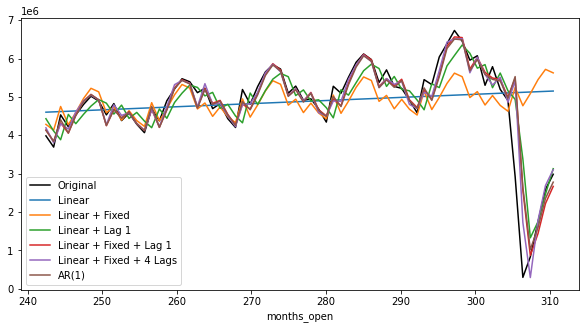

In [72]:
f,ax = plt.subplots(figsize=(10,5))

# Make a temporary DataFrame for to "zoom in"
_df = shift_df.loc['2015-01-01':]

# Start visualizing
_df.plot.line(x='months_open',y='Total',c='k',label='Original',ax=ax)
_df.plot.line(x='months_open',y='m0',c='tab:blue',label='Linear',ax=ax)
_df.plot.line(x='months_open',y='m1',c='tab:orange',label='Linear + Fixed',ax=ax)
_df.plot.line(x='months_open',y='m2',c='tab:green',label='Linear + Lag 1',ax=ax)
_df.plot.line(x='months_open',y='m3',c='tab:red',label='Linear + Fixed + Lag 1',ax=ax)
_df.plot.line(x='months_open',y='m4',c='tab:purple',label='Linear + Fixed + 4 Lags',ax=ax)
_df.plot.line(x='months_open',y='m5',c='tab:brown',label='AR(1)',ax=ax)

We can also plot the residuals for the most recent dates. There are massive negative residuals when the COVID-19 shutdowns happen in March and April when the models over-estimate the number of passengers based on the previous trends. But the models with auto-regressive terms (m2, m3, m4, m5) rapidly recover in performance and have more normal residuals within a few months despite the massive disruption.

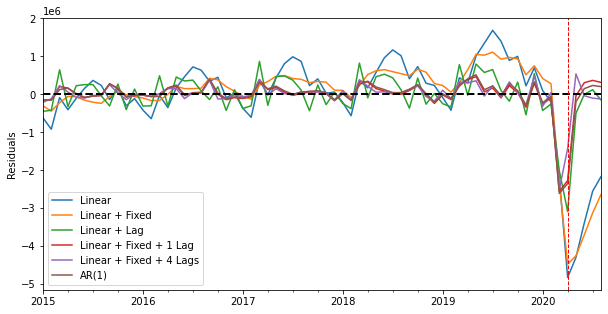

In [74]:
residuals_df['AR(1)'] = m5.resid

f,ax = plt.subplots(figsize=(10,5))
residuals_df.loc['2015-01-01':].plot(ax=ax)

# Annotate
ax.set_ylabel('Residuals')
ax.axhline(0,c='k',ls='--',lw=2)
ax.axvline(pd.Timestamp('2001-09-01'),c='r',ls='--',lw=1)
ax.axvline(pd.Timestamp('2008-09-01'),c='r',ls='--',lw=1)
ax.axvline(pd.Timestamp('2020-04-01'),c='r',ls='--',lw=1)

We can also visualize m5's forecast going forward.

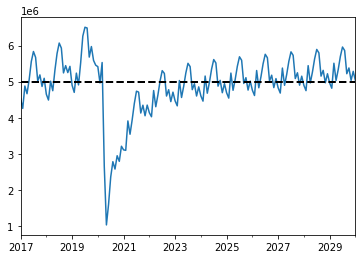

In [86]:
m5_forecast = m5.predict(start='2017-01-01',end='2030-01-01')

ax = m5_forecast.plot()
ax.axhline(5e6,c='k',ls='--',lw=2)

We could also use `m5`'s `.plot_predict()` method to visual the range of outcomes that are possible.

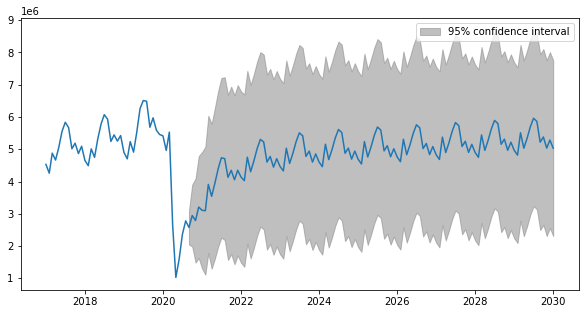

In [87]:
p = m5.plot_predict(start='2017-01-01',end='2030-01-01',figsize=(10,5))

## Forecasting with BEST data (in-class)

First: Read in the BEST temperature data, cast the months column to a `Timestamp` or `Period` object, set as an index, and describe the data. Also rename the "1M Anomaly" column to "Anomaly1M" since this will save some headaches when we get to the statsmodel estimation. Finally, `.fillna(0)` to cast the missing "1M Anomaly" data to 0.

In [19]:
best_df = pd.read_csv('berkeley_temps.csv',parse_dates=['Date'])

print(best_df.shape)
# Put the date in the index
best_df.set_index('Date',inplace=True)

# Reindex to make sure data is continuous
best_df = best_df.reindex(pd.date_range('1750-01-01','2020-08-01',freq='MS'),fill_value=0)
print(best_df.shape)

# Rename columns
best_df.rename(columns={'1M Anomaly':'A1M',
                        '1Y Anomaly':'A1Y',
                        '5Y Anomaly':'A5Y',
                        '10Y Anomaly':'A10Y',
                        '20Y Anomaly':'A20Y'
                       },inplace=True)

best_df['A1M'].fillna(0,inplace=True)

best_df.tail(20)

(3248, 11)
(3248, 10)


,A1M,1M Uncertainty,A1Y,1Y Uncertainty,A5Y,5Y Uncertainty,A10Y,10Y Uncertainty,A20Y,20Y Uncertainty
2019-01-01,1.437,0.075,1.221,0.037,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,1.219,0.065,1.232,0.038,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,1.827,0.060,1.259,0.038,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,1.554,0.064,1.270,0.039,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,1.019,0.078,1.301,0.043,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01,1.045,0.044,1.342,0.045,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01,1.173,0.074,1.392,0.046,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,1.124,0.068,1.465,0.045,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,1.211,0.068,1.460,0.043,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,1.528,0.139,1.473,0.045,NaN,NaN,NaN,NaN,NaN,NaN


Second: Make a plot of the "1M anomaly" data (ideally really wide). Also experiment with the 1Y, 5Y and other windows.

Text(0, 0.5, 'Temperature anomaly')

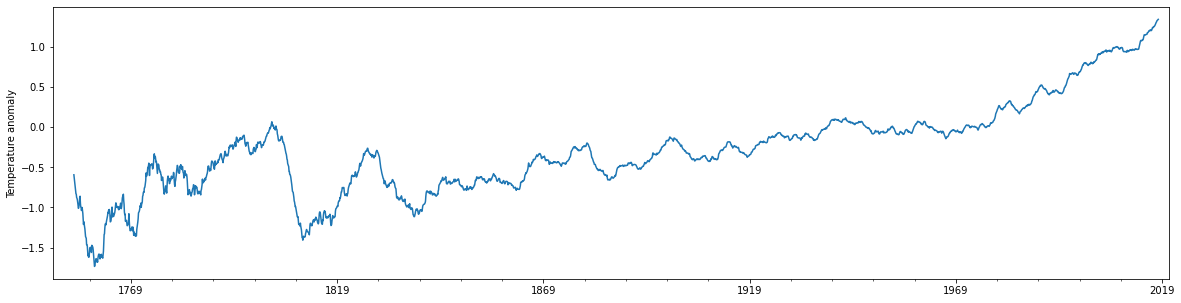

In [36]:
f,ax = plt.subplots(figsize=(20,5))

best_df['A5Y'].plot(ax=ax)
ax.set_ylabel('Temperature anomaly')

Third: make a new column "elapsed" that (similar to the "months_open" variable from above) where the values are `float`s of the number of days since January 1750.

In [32]:
best_df['elapsed'] = (best_df.index - pd.Timestamp('1750-01-01'))/pd.Timedelta(30,'D')
best_df['month'] = [i.month for i in best_df.index]

best_df.head()

,A1M,1M Uncertainty,A1Y,1Y Uncertainty,A5Y,5Y Uncertainty,A10Y,10Y Uncertainty,A20Y,20Y Uncertainty,elapsed,month
1750-01-01,-0.652,3.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1
1750-02-01,-1.223,4.059,-1.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.033333,2
1750-03-01,0.065,3.250,-1.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.966667,3
1750-04-01,-0.399,2.059,-1.108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,4
1750-05-01,-1.838,3.638,-1.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,5


Fourth: use statsmodel's formula functionality to specify an estimate a simple regression model using the "elapsed" as a predictor and the "1M anomaly" as an outcome variable. Alternatively, estimate a more advanced regression model that includes fixed effects on the month. Or an autoregressive term.

In [39]:
best_m0 = smf.ols('A1Y ~ elapsed',data=best_df).fit()

best_m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    A1Y   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     4711.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:44:15   Log-Likelihood:                -1661.2
No. Observations:                3229   AIC:                             3326.
Df Residuals:                    3227   BIC:                             3339.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1476      0.014    -80.080      0.000      -1.176      -1.119
elapsed        0.0005   7.53e-06     68.640      0.000       0.001       0.001
==============================================================================
Omnibus:                      110.340   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.472
Skew:                           0.311   Prob(JB):                     7.88e-39
Kurtosis:                       3.957   Cond. No.                     3.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Fifth: interpret the estimated parameters and performance of this regression model.

In [42]:
_future = pd.date_range('2000-01-01','2040-01-01', freq='MS')
_future_elapsed = (_future - pd.Timestamp('1750-01-01'))/pd.Timedelta(30,'D')

best_future_df = pd.DataFrame({'elapsed':_future_elapsed},
                              index = _future
                             )

best_future_df.tail()

,elapsed
2039-09-01,3526.600000
2039-10-01,3527.600000
2039-11-01,3528.633333
2039-12-01,3529.633333
2040-01-01,3530.666667


Sixth: make a new DataFrame that goes a few years/decades into the future. Use the `.predict()` method on the fitted model from step 4 with the extended dates to forecast the future temperatures.

In [44]:
best_future_df['m0'] = best_m0.predict({'elapsed':best_future_df['elapsed']})

best_future_df.tail()

,elapsed,m0
2039-09-01,3526.600000,0.675882
2039-10-01,3527.600000,0.676399
2039-11-01,3528.633333,0.676934
2039-12-01,3529.633333,0.677451
2040-01-01,3530.666667,0.677985


Seventh: visualize the model predictions going into the future.

<AxesSubplot:>

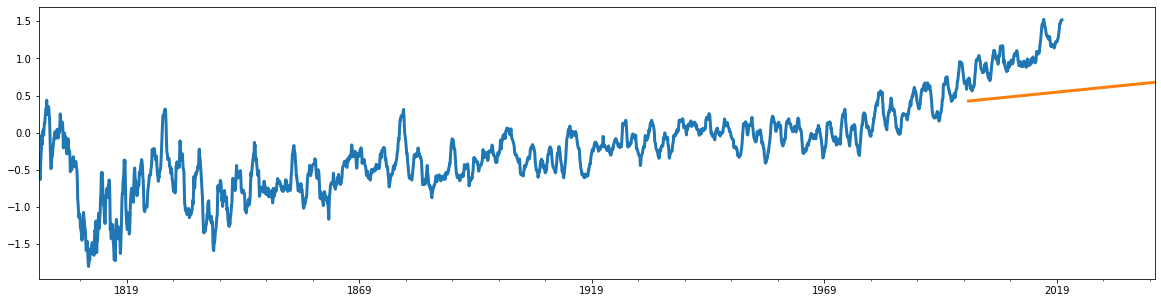

In [52]:
f,ax = plt.subplots(figsize=(20,5))

best_df.loc['1800-01-01':,'A1Y'].plot(ax=ax,lw=3)
best_future_df['m0'].plot(ax=ax,lw=3)

Use the autoregression model we introduced in this lecture instead.

The model's prediction are a superficially poor fit to the underlying trend in the data and don't capture the accelerating increase in temperatures.

## fbprophet (time permitting)

[Prophet](https://facebook.github.io/prophet/) is a time series forecasting tool developed (and obviously used by) data scientists at Facebook. There are a variety of more advanced statistical methods for modelling time series ([ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model), [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), SARIMA, *etc*.) but these often involve doing computation-intensive [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization) to find appropriate parameters or having deep understanding of the data or a theory to translate into parameters. Forecasting methods like ARMA, ARIMA, *etc*. are outside the scope of the class.

The reason we're looking at Prophet is because it does all of these (and more!), *mostly* automatically. Definitely check out the [documentation](https://facebook.github.io/prophet/) and examples in both R and Python.

I've adapted the [Getting Started](https://facebook.github.io/prophet/docs/quick_start.html#python-api) documentation for our purposes here. Prophet wants a simple DataFrame containing only a column "ds" with timestamps and a column "y" with values for that date.

**AT THE TERMINAL WINDOW**, run this command and agree to update when it requests:

`conda install -c conda-forge fbprophet`

In [53]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


Reshape the data into a format that the Prophet wants.

In [56]:
best_temp_prophet = best_df['A1Y'].copy().reset_index()

best_temp_prophet.columns = ['ds','y']

best_temp_prophet.head()

,ds,y
0,1750-01-01,NaN
1,1750-02-01,-1.052
2,1750-03-01,-1.078
3,1750-04-01,-1.108
4,1750-05-01,-1.420


Fit the model. Since this data is at the monthly level, we do not need Prophet to estimate weekly or daily seasonality patterns. If you had data at the weekly or daily level, you probably would want it to estimate those. A few errors in red may be thrown and it should take a couple seconds for the estimation to finish.

In [57]:
best_m2 = Prophet(weekly_seasonality=False,daily_seasonality=False).fit(best_temp_prophet)

We can use the `make_future_dataframe` method attached to the `m3` model we just estimated to make predictions into the future. Let's estimate a decade into the future, or 20 years \* 12 months/year = 240 months. Make sure to specify the "freq='M'" option, or it will default to daily estimates which doesn't make much sense for our monthly data.

Make the predictions.

Inspect the predictions made by Prophet. This will include the historical data (black points), the line connecting these points, and the forecast into the future with errors.

It's also worth reading this October 5, 2020 *New Yorker* article "[Three Scenarios for the Future of Climate Change](https://www.newyorker.com/news/annals-of-a-warming-planet/three-scenarios-for-the-future-of-climate-change)" by Elizabeth Kolbert.